# OpenAI gymのチュートリアル 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

### 描画のための処理

[こちら](https://stackoverflow.com/a/61318224)あるいは[こちら](https://stackoverflow.com/a/61318224)を参考にした．

In [3]:
!apt-get install -y xvfb x11-utils
!pip install -q gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 13 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 993 kB in 1s (1,319 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:

In [5]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

### 環境の作成

In [7]:
import gym

今回は連続状態・離散行動の環境であるカートポールを利用する． 

In [8]:
env = gym.make("CartPole-v0")
print("observation space:", env.observation_space)
print("action space:", env.action_space)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


### 環境の初期化 

初期状態を取得

In [9]:
obs=env.reset()
print("initial observe:",obs)

initial observe: [ 0.03319903 -0.0308145   0.03269363  0.03263217]


### 状態の遷移 

今回は，離散の行動空間からサンプリングして状態を遷移させる．

In [10]:
max_episode_len = 200

R = 0  # Return (sum ofrewards)
t = 0  # time step
while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    R += reward
    t += 1
    reset = t == max_episode_len
    # 通常ここでエージェントが観測し，学習を行う
    if done or reset:
        break

もちろんここで分かるのはエピソード数(終了判定までの長さ)と報酬，その合計であるので，どのように状態が遷移したか分かりにくい．そこで環境の可視化のために，`env.render`が利用できる．一般的に`mode`という引数が存在する．環境の可視化を画像として保存するには通常`mode`を`rgb_array`にすればよい．

### 環境の可視化 

#### 動画として保存 

In [11]:
%matplotlib inline

In [12]:
print(env.viewer)

None


ここで注意しなければならないのは，`env.render`を利用するなら必ず環境を明示的にクローズする必要があることである．

image shape: (400, 600, 3)


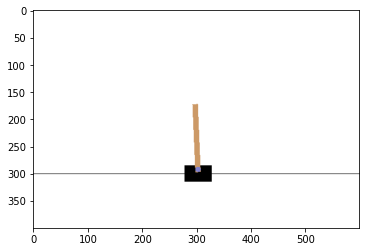

In [13]:
env.reset()
image_array = env.render(mode="rgb_array")
print("image shape:",image_array.shape)
fig, ax = plt.subplots()
ax.imshow(image_array)
env.close()

In [14]:
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('/content/gdrive/MyDrive/rl_tutorial/movies/gym_tutorial.mp4', fourcc, 10, (600, 400))

max_episode_len = 200

R = 0  # Return (sum ofrewards)
t = 0  # time step
env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    R += reward
    t += 1
    reset = t == max_episode_len
    # 画像として取得，保存
    frame = env.render(mode="rgb_array")
    out.write(frame[:,:,::-1])
    
    if done or reset:
        break
        
env.close()
out.release()

print("episode length:", t)

episode length: 49


ポールがある傾きを超えるとdoneがTrueになり，エピソードが終了する．

### 行動の種類と最大・最小 

#### 離散行動の場合

行動を取得してみる

In [15]:
action = env.action_space.sample()
print(action)
print(type(action))

0
<class 'int'>


0からクラス数-1までの整数値で出力される．one-hotで取得されないことに注意

行動空間のサイズは`n`で取得する．

In [16]:
env.action_space.n

2

#### 連続行動の場合 

振り子を上に保つペンデュラムを利用する

In [17]:
pendulum_env = gym.make("Pendulum-v0")
action = pendulum_env.action_space.sample()
print(action)
print(type(action))

[-0.37034488]
<class 'numpy.ndarray'>


実数値のndarrayで取得される．

連続行動の最大値，最小値，次元数は以下のように取得できる

In [18]:
pendulum_env.action_space.low

array([-2.], dtype=float32)

In [19]:
pendulum_env.action_space.high

array([2.], dtype=float32)

In [20]:
pendulum_env.action_space.low.size

1

### 行動の上限を超えた場合 

In [23]:
env.reset()
obs, reward, done, info =  env.step(2)
env.close()

AssertionError: ignored

In [24]:
pendulum_env.reset()
obs, reward, done, info = pendulum_env.step(np.array([4]))
pendulum_env.close()

連続行動の場合は何もエラーが出ない，おそらくクリッピングされている？

In [25]:
pendulum_env.reset()
obs, reward, done, info = pendulum_env.step(np.array([1,1,1,1]))
pendulum_env.close()

実は，次元が違っても何でもあり．これは環境側のソースコードで`u = np.clip(u, -self.max_torque, self.max_torque)[0]`となっていることから，クリップしさらにその最初の値のみを取得しているためである．このように連続な行動では，環境側で上限・下限の
チェックを行う．